# IBMQX direct randomized benchmarking data analysis.
Original version: 06/28/2018. This version: 07/29/2019 (pyGSTi compatability updates).

An ipython notebook containing the analysis of the IBMQX DRB experiments, and specifications for how the DRB sequences were generated.

To use this notebook it is necessary to install the python package `pyGSTi` http://www.pygsti.info. This notebook should be used with `pygSTi` version 0.9.8, the latest version as of this writing.

This notebook is **not** intended as a demonstration of how to use `pyGSTi` to generate DRB circuits for a particular device. For information on how to do this, see the ipython notebook tutorials contained within `pyGSTi`. Furthermore, in this notebook there are limited details of the various `pyGSTi` object that are used (e.g., `pyGSTi` circuits). For this information, see the `pyGSTi` tutorials and documentation.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports for python2 compatability.
from __future__ import division, print_function, absolute_import, unicode_literals

# pyGSTi imports. This code requires pyGSTi version 0.9.8
import pygsti
from pygsti.extras import rb

# Imports a local .py file containing information about the experiments (e.g., calibration data).
import metadata

/Users/tjproct/files/programs/pyGSTi/packages/pygsti/objects/processorspec.py:481: UserWarning:

The identity should often *not* be included in the root gate names of a ProcessorSpec.



## 1. Accessing the data

The experimental data is in the folder "data", in files with names "Ss_nQ_Bb_data.txt" where "s" = 1,2, "n" = 2,3,4,5 and "b" = 0,1,2,3. 

- The "s" refers to the sampling used. "s" = 1 ("s" = 2 resp.,) is data for the sampling described in the text with $p_{cnot} = 0.75$ ($p_{cnot} = 0.25$ resp.,).
- The "n" refers to the number of qubits, e.g., the files with "n" = 2 contain data for 2-qubit DRB.
- The "b" refers to the "batch". The data for each "s" and "n" was obtained in 4 sequential jobs submitted to IBMQX, due to the limitations on the number of different circuits that can be submitted in a single job on IBMQX. The data has been stored by batch, which we group together in the analysis below.

Each file consists of 4 columns. Each row contains data from one random circuit. The row consists of the RB length, the number of success counts observed, the total counts for this circuit (here, always 1024), the circuit depth of the circuit that the data is for, and the 2-qubit gate count (here, the CNOT count) of the circuit that the data is for. 

This only summarizes the full data obtained from IBMQX, because IBMQX returns counts for all the possible bit-string outcomes. But, for the purposes of RB a "success/fail" outcome is all that is relevant, so this is all that we store here.

These data files only summarize the most useful information about what each random circuit is. But, the exact circuits run are stored in the "circuits" folder, and are imported later in this notebook. These circuits are `pyGSTi` circuit objects (stored as plain text), and so to implement them on IBMQX it is necessary to convert them to QASM files. These QASM files (one for each circuit) are stored in the "QASM" folder, and they show the precise instructions submitted to IBMQX for each circuit. We do not use these QASM files in this notebook.

### Importing the data

To import the data, we use a `pyGSTi` function that reads in this "summary" RB data, arranges it, and stores it in a basic object.

In [2]:
# Strings corresponding to the two different samplers
samplers = ['S1','S2']
# There is data for 2, 3, 4 and 5 qubits
number_of_qubits = [2,3,4,5]
# There are 4 batches of data for each sampling and qubit number.
batchlist = list(range(4))

In [3]:
# A dictionary to hold the imported data
data = {}
for s in samplers:
    for n in number_of_qubits:
        # A list of the filenames for the data with this s and n.
        filenames = ['data/'+s+'_'+str(n)+'Q_B{}_data.txt'.format(b) for b in batchlist]
        # This imports the data, into an RBSummaryDataset object.
        data[s,n] = rb.io.import_rb_summary_data(filenames, verbosity=0)

Let's look at where the data are stored. To do this, pick a particular (s,n) pair to look at:

In [4]:
s = 'S1'
n = 2

The two most important quantities are:
1. The "DRB lengths". That is, the lengths of the "core" sequence in DRB, consisting of circuit layers sampled according to the user-specified distribution.
2. The corresponding observed average success probabilities.

These are stored here:

In [5]:
print(data[s,n].lengths)
print(data[s,n].ASPs)

[0, 5, 10, 15, 20, 25, 30]
[0.9395577566964286, 0.8503766741071429, 0.7797502790178571, 0.7108328683035714, 0.6653180803571429, 0.5890066964285714, 0.5718122209821429]


The per-circuit information is also stored, as the following lists of lists with (hopefully) self-explanatory names. The first index of these lists of lists corresponds to data at the sequence length with the same index.

Here we look at the per-circuit data for the first sequence length (in this case, length 0 for the central circuit).

In [6]:
print(data[s,n].success_counts[0])
print(data[s,n].total_counts[0])
print(data[s,n].circuit_depths[0])
print(data[s,n].circuit_twoQgate_counts[0])

[987, 927, 920, 974, 925, 946, 981, 934, 992, 974, 946, 977, 927, 978, 983, 981, 976, 975, 920, 992, 988, 996, 933, 993, 933, 932, 970, 979]
[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
[4, 8, 8, 3, 8, 8, 4, 8, 4, 4, 8, 4, 8, 4, 2, 4, 4, 3, 8, 4, 2, 0, 8, 1, 8, 8, 3, 2]
[0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0]


### Plotting the data
We'll want to plot data throughout this notebook, so here define a function that plots success probabilities against length (both the average and per-circuit success probabilities).

In [7]:
def plot_data(data, estimates=None, size=(6,2), ylim=(0,1)):
    
    plt.figure(figsize=size)
    plt.plot(data.lengths,data.ASPs,'o')
    lengths = np.linspace(0,max(data.lengths),200)
    
    if estimates is not None:
        A = estimates['A']
        B = estimates['B']
        p = estimates['p']
        plt.plot(lengths,A+B*p**lengths)
    plt.violinplot(list(data.success_probabilities),data.lengths,points=10, widths=1., showmeans=True, 
                   showextrema=False, showmedians=False)
    
    plt.title("Results for {} Sampling DRB on {} qubits".format(s,n))
    plt.ylabel("Success probability")
    plt.xlabel("Core seqence length $(m)$")
    plt.ylim(ylim)
    
    plt.show()

Let's look at some data:

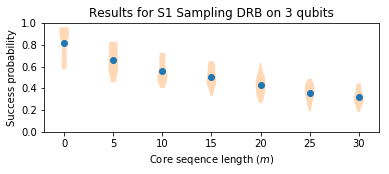

In [8]:
s = 'S1'
n = 3
plot_data(data[s,n])

## 2. Fitting the data

We analyze the data using least-squares fitting. We implement this using the `rb.analysis.std_least_squares_data_fitting()` function, which is a wrapper for `scipy.optimize.curve_fit()`.

As with some of our simulated data (see the other notebooks in this supplementary material), some of this experimental data does not contain much information about the asymptotic average success probability. So, we fix this asymptotic value, as is common-practice when analyzing experimental RB data. By plotting the data (using the cell above) we can see that the observed decays do not appear to be asymptoting to $1/2^n$. This is probably due to biased measurement errors (we did not randomize the ideal circuit output -- it was fixed to $|0\rangle^{\otimes n}$). So we guess the asymptote by fitting the "S1" data to $P_m = A + Bp^m$, and then, throughout the rest of the analysis, we fix $A$ to the value obtained (with a different $A$ for each $n$).

In [9]:
# Seeds for B and p in P_m = A + Bp^m (A is automatically seeded to 1/2**n). 
seed = {}
seed[2] = [0.9,0.97]
seed[3] = [0.6,0.96]
seed[4] = [0.3,0.95]
seed[5] = [0.1,0.94]

# A dict to hold fit results
fit = {}
s = 'S1'
for n in number_of_qubits:
    # This fits the data to P_m = A + Bp^m
    fit[s,n] = rb.analysis.std_least_squares_data_fitting(data[s,n].lengths, data[s,n].ASPs, n, seed=seed[n])

The `fit[s,n]` items are dictionaries with the estimated values saved under the key `estimates`. Other keys just contain information about the fit success etc, and are not important here.

In [10]:
print(fit[s,2]['estimates'])

{'A': 0.28767999816720824, 'B': 0.6517092896937966, 'p': 0.971789079134669, 'r': 0.026447738311247762}


As we are going to fix $A$ to the values obtained here, it is useful to check that the fits look reasonable.

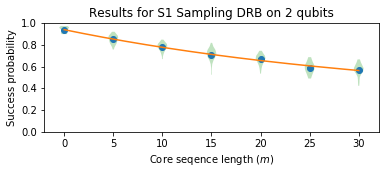

In [11]:
n = 2
plot_data(data['S1',n],estimates=fit[s,n]['estimates'])

We then fit all of the data to $P_m = A + Bp^m$ with $A$ fixed as described above.

In [12]:
A = {}
for s in samplers:
    for n in number_of_qubits:
        A[s,n] = fit['S1',n]['estimates']['A']
fit = {}
for s in samplers:
    for n in number_of_qubits:
        # With `ftype` set to 'FA' this function fits to A + Bp^m with A fixed to `asymptote`.
        fit[s,n] = rb.analysis.std_least_squares_data_fitting(data[s,n].lengths, data[s,n].ASPs, n, 
                                                              asymptote=A[s,n], seed=seed[n], ftype='FA')

We can now look at our point-estimates for the DRB error rates. These correspond to the numbers presented/used in the main text. As specified in the text, $r = (4^n - 1)(1-p)/4^n$.

In [13]:
r = {}
for n in number_of_qubits:
    for s in samplers:
        r[s,n] =  fit[s,n]['estimates']['r']
        print("Estimated DRB error rate for {} sampling and {} qubits: {}".format(s,n,r[s,n]))
    print('')

Estimated DRB error rate for S1 sampling and 2 qubits: 0.026447738116935696
Estimated DRB error rate for S2 sampling and 2 qubits: 0.010759064803364145

Estimated DRB error rate for S1 sampling and 3 qubits: 0.04267225394565081
Estimated DRB error rate for S2 sampling and 3 qubits: 0.01768813992805219

Estimated DRB error rate for S1 sampling and 4 qubits: 0.06863466515744918
Estimated DRB error rate for S2 sampling and 4 qubits: 0.03050614391829304

Estimated DRB error rate for S1 sampling and 5 qubits: 0.16053799346397238
Estimated DRB error rate for S2 sampling and 5 qubits: 0.06481919248326892



### Generating bootstrapped confidence intervals
We can obtain confidence intervals using a bootstrap. To do this, we first generate (non-parameteric) bootstrapped datasets, using a standard boostrap. This is achieved using a method of the ``RBSummaryDataset`` object (the items of the `data` dictionary).

In [14]:
number_of_bootstraps = 1000

for s in samplers:
    for n in number_of_qubits:
        print("Generating {} bootstrapped datsets... ".format(number_of_bootstraps),end='')
        data[s,n].add_bootstrapped_datasets(number_of_bootstraps)
        print("complete.")

Generating 1000 bootstrapped datsets... complete.
Generating 1000 bootstrapped datsets... complete.
Generating 1000 bootstrapped datsets... complete.
Generating 1000 bootstrapped datsets... complete.
Generating 1000 bootstrapped datsets... complete.
Generating 1000 bootstrapped datsets... complete.
Generating 1000 bootstrapped datsets... complete.
Generating 1000 bootstrapped datsets... complete.


We then repeat the fitting procedure above on these bootstrapped datasets:

In [15]:
# A dict to hold the bootstrapped r estimates
bootstrapped_r = {}
# A dict to hold the fail count of the fit (a flag to warn us if the fit is not working)
failcount = {}
for s in samplers:
    for n in number_of_qubits:
        bootstrapped_r[s,n] = []
        failcount[s,n] = 0
        for i in range(number_of_bootstraps):
            bs_fit = rb.analysis.std_least_squares_data_fitting(data[s,n].lengths, data[s,n].bootstraps[i].ASPs, n, 
                                                                asymptote=A[s,n], seed=seed[n], ftype='FA')
            if bs_fit['success']:                
                bootstrapped_r[s,n].append(bs_fit['estimates']['r'])
            else:
                failcount[s,n] += 1
        # This tells us how often the fit fails.
        print("{} sampling and {} qubits fit fail percentage: {}".format(s,n,failcount[s,n]/number_of_bootstraps))

S1 sampling and 2 qubits fit fail percentage: 0.0
S1 sampling and 3 qubits fit fail percentage: 0.0
S1 sampling and 4 qubits fit fail percentage: 0.0
S1 sampling and 5 qubits fit fail percentage: 0.0
S2 sampling and 2 qubits fit fail percentage: 0.0
S2 sampling and 3 qubits fit fail percentage: 0.0
S2 sampling and 4 qubits fit fail percentage: 0.0
S2 sampling and 5 qubits fit fail percentage: 0.0


We can then inspect the bootstrapped estimates of $r$, by histogramming them. They look reasonably Gaussian (although they are a bit skewed in some cases), so the standard deviation of these estimates is a reasonable quantification of estimation uncertainty.

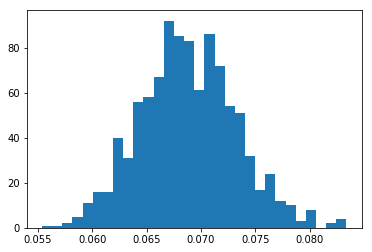

In [16]:
s = 'S1'
n = 4
plt.hist(bootstrapped_r[s,n],bins=30)
plt.show()

In [17]:
# A dict to hold the bootstrapped standard deviations
r_std = {}
for s in samplers:
    for n in number_of_qubits:
        r_std[s,n] = np.std(np.array(bootstrapped_r[s,n]))

### The estimated DRB error rates
To end our analyze of extracting the DRB error rates from the data, let's look again at our $r$ estimates now that they have uncertainties on them:

In [18]:
for n in number_of_qubits:
    for s in samplers:
        r[s,n] =  fit[s,n]['estimates']['r']
        print("Estimated r for {} sampling and {} qubits: {} +/- {}".format(s,n,r[s,n],r_std[s,n]))
    print('')

Estimated r for S1 sampling and 2 qubits: 0.026447738116935696 +/- 0.0007145888360009634
Estimated r for S2 sampling and 2 qubits: 0.010759064803364145 +/- 0.0003698385380317662

Estimated r for S1 sampling and 3 qubits: 0.04267225394565081 +/- 0.0020951596176400846
Estimated r for S2 sampling and 3 qubits: 0.01768813992805219 +/- 0.001410849451248798

Estimated r for S1 sampling and 4 qubits: 0.06863466515744918 +/- 0.004433702676664019
Estimated r for S2 sampling and 4 qubits: 0.03050614391829304 +/- 0.0028044139538224797

Estimated r for S1 sampling and 5 qubits: 0.16053799346397238 +/- 0.033019718851087246
Estimated r for S2 sampling and 5 qubits: 0.06481919248326892 +/- 0.014919678256659687



## 3. Comparing the observed results with predictions from the calibration data

IBMQX results come with data about the error rates for the gates/measurements at the time of the last calibration. This calibration data is obtained from 1- and 2-qubit CRB, so this calibration data allows us to compare the results of $n$-qubit DRB with the $n$-qubit error rates that would be predicted from 1- and 2-qubit CRB error rates.

### Extracting error rates from the calibration data

We need to convert the calibration data into the relevant error rates for $n$-qubit gates. The error rates are 1- and 2-qubit Clifford RB error rates, and the CRB error rate is traditionally defined as

$r = (2^n -1)(1-p)/2^n$

where $p$ is, as in DRB, obtained from fitting to $A + Bp^m$. So, $r$ does not correspond to the probability of error for the gate. It must be rescaled by mapping $r \to p$ and then $p \to (4^n - 1)(1-p)/4^n$. So, below we use this conversation to find the error rates (according to 1- and 2-qubit CRB) of the 1- and 2-qubit gates. These can then be used to predict the error rate of parallel applications of these gates. In particular, the error rate of an $n$-qubit gate consisting of parallel application of gates with error rates $\epsilon_1$, $\epsilon_2$, $\dots$ is taken to be $1 - (1-\epsilon_1)(1-\epsilon_2)\dots$.

Below we estimate these $n$-qubit error rates for all $n$-qubit gates used in the DRB experiments.

In [19]:
# To store the calibration-data-derived error rates of the 1-qubit gates
oneQ_gate_error_rates = {}
# To store the calibration-data-derived error rates of the CNOT gates
twoQ_gate_error_rates = {}
# To store the mean calibration-data-derived error rates of the CNOT gates. We will be interested in
# this later.
mean_twoQ_gate_error_rate = {}
# To store the calibration-data-derived error rates of the prep-measure operation on individual qubits.
# We will uses these later, when we implement DRB simulations based on the calibration data.
SPAM_error_rates = {}

In [20]:
for s in samplers:
    for n in number_of_qubits:

        # The calibration data, which is a dictionary containing various error rate.
        cal = metadata.calibration[s]
        oneQ_gate_error_rates[s,n] = {}
        twoQ_gate_error_rates[s,n] = {}
        SPAM_error_rates[s,n] = {}
        
        # The qubits we used, in the IBMQX labelling
        IBMQX_qubits = metadata.IBMQX_qubits_used[n]
        # A mapping to the 0,1,..,n labelling we used in our cirucits. We store the error
        # rates by this labelling as this is more convenient for our simulations (see later).
        IBMQX_to_circuits = metadata.IBMQX_to_circuits_qubit_labelling[n]

        mean_twoQ_gate_error_rate[s,n] = []
        
        # This goes through the multi-qubit gates and stores the error rates for the ones we used.
        for dct in cal['multiQubitGates']:
            
            IBMQX_q1 = dct['qubits'][0]
            IBMQX_q2 = dct['qubits'][1] 
            
            # Only record the gate error rate if this is of a gate we use in the DRB circuits
            if (IBMQX_q1 in IBMQX_qubits) and (IBMQX_q2 in IBMQX_qubits):
                # We record the error rate of the gates using the labelling used in the ProcessorSpec and circuits
                q1 = IBMQX_to_circuits[IBMQX_q1]
                q2 = IBMQX_to_circuits[IBMQX_q2]
                # This is the inverse of the function r = (2^n -1)(1-p)/2^n with n = 2.
                dep = rb.analysis.r_to_p(dct['gateError']['value'],d=4,rtype='AGI')
                # This is the mapping r = (4^n -1)(1-p)/4^n with n = 2.
                error_rate = rb.analysis.p_to_r(dep,d=4,rtype='EI')                
                twoQ_gate_error_rates[s,n][q1,q2] = error_rate
                
                # Store the 2-qubit error rates in a list to average
                mean_twoQ_gate_error_rate[s,n].append(error_rate)
        
        # The average CNOT error rate.
        mean_twoQ_gate_error_rate[s,n] = np.mean(np.array(mean_twoQ_gate_error_rate[s,n]))
        
        # This goes through the qubits and stores the error rates of the 1-qubit gates and measurements
        # for the qubits we used.
        for dct in cal['qubits']:
            
            # This gives the IBMQX qubit index.
            IBMQX_q = int(dct['name'][1:])
             
            # Only record the gate error rate if this is of a gate we use in the DRB circuits
            if IBMQX_q in IBMQX_qubits:
                
                q = IBMQX_to_circuits[IBMQX_q]
                # This is the inverse of the function r = (2^n -1)(1-p)/2^n with n = 1.
                dep = rb.analysis.r_to_p(dct['gateError']['value'],d=2, rtype='AGI')
                # This is the mapping r = (4^n -1)(1-p)/4^n with n = 1.
                error_rate = rb.analysis.p_to_r(dep,d=2,rtype='EI')                
                oneQ_gate_error_rates[s,n][q] = error_rate
                
                # The measurement error is just stored as the value given. (to our knowledge
                # this error rate corresponds to the rate of error in the prep/measure experiment)
                SPAM_error_rates[s,n][q] = dct['readoutError']['value']

### Predicting DRB error rates from the calibration data and our DRB theory

From the calibration-predicted error rates of the $n$-qubit gates, we can then predict the DRB error rate. In particular, we predict $r$ to be the average of these error rates, weighted according to the sampling probabilities, via the theory of DRB we presented in the main text.

In [21]:
# The probabilities of sampling a layer containing a single CNOT.
CNOT_prob = {}
CNOT_prob['S1'] = 0.75
CNOT_prob['S2'] = 0.25

In [22]:
# A dictionary for storing the calibration-predicated DRB error rates.
cal_predicted_r = {}
for s in samplers:
    for n in number_of_qubits:
        
        # This calculates the error rate of an n-qubit gate containing n parallel 1-qubit gates
        oneQgatesonly_LSP = 1
        for q in range(n): 
            oneQgatesonly_LSP = oneQgatesonly_LSP*(1- oneQ_gate_error_rates[s,n][q])
        
        oneQgatesonly_error_rate = 1 - oneQgatesonly_LSP
        
        oneCNOT_with_1Qs_error_rates = []
        
        # The (ordered) pairs of qubits a CNOT can be applied to.
        CNOT_pairs = metadata.CNOT_edge_list[n]
        
        # This calculates the error rates of those n-qubit gate containing one CNOT in parallel 
        # with 1-qubit gates on the other qubits.
        for tup in CNOT_pairs:
            
            # This calculates the error rate of an n-qubit gate containing the CNOT specified by
            # the pair `tup` in parallel with 1-qubit gates on the other qubits.
            LSP = 1-twoQ_gate_error_rates[s,n][tup]
            for q in range(n):            
                if q not in tup:            
                    LSP = LSP*(1-oneQ_gate_error_rates[s,n][q])
            
            oneCNOT_with_1Qs_error_rates.append(1-LSP)
            
        mean_oneCNOT_with_1Qs_error_rate = np.mean(np.array(oneCNOT_with_1Qs_error_rates))
        
        # The r predicted by our theory of DRB and the error rates estimated above
        cal_predicted_r[s,n] = (1-CNOT_prob[s])*oneQgatesonly_error_rate \
                                + CNOT_prob[s]*mean_oneCNOT_with_1Qs_error_rate
        print('{} qubits with {} sampling, calibration predicted r = {}'.format(n,s,cal_predicted_r[s,n]))
    print('')

2 qubits with S1 sampling, calibration predicted r = 0.027880876824274953
3 qubits with S1 sampling, calibration predicted r = 0.02980421881749587
4 qubits with S1 sampling, calibration predicted r = 0.040129586240170496
5 qubits with S1 sampling, calibration predicted r = 0.04320740706536

2 qubits with S2 sampling, calibration predicted r = 0.013449896586314486
3 qubits with S2 sampling, calibration predicted r = 0.014960259195249376
4 qubits with S2 sampling, calibration predicted r = 0.020630856587016237
5 qubits with S2 sampling, calibration predicted r = 0.023702504084574444



Let's plot these predictions against the observed values.

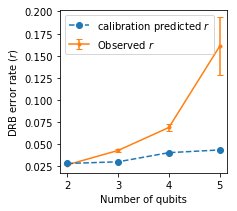

In [23]:
s = 'S1'
plt.figure(figsize=(3,3))
plt.plot(number_of_qubits,[cal_predicted_r[s,n] for n in number_of_qubits],'o--',label='calibration predicted $r$')
rlist = [r[s,n] for n in number_of_qubits]
rstdlist = [r_std[s,n] for n in number_of_qubits]
plt.errorbar(number_of_qubits, rlist, yerr=rstdlist, zorder=0, fmt='.-',capsize=3.,label='Observed $r$')
plt.xlabel("Number of qubits")
plt.ylabel("DRB error rate ($r$)")
plt.legend()
plt.show()

### Predicting DRB error rates from the calibration data and simulations of DRB

The above predictions of $r$ from the calibration data relied on our theory of DRB. So, the lack of agreement between the observed and predicted $r$ for $n > 2$ could be for two reasons:

1. The gates in IBMQX5 perform worse in circuits over more qubits. That is, even ideal characterization or benchmarking of isolated pairs of qubits would not predict the behaviour of $n > 2$ qubit circuits.
2. Our theory for DRB is wrong, and the deviation of the observed $r$ and predicted $r$ is due to a failing in DRB. E.g., the results of $n$-qubit CRB or full $n$-qubit tomography, if it was feasable, would be consist with predictions from the 1- and 2-qubit CRB data.

We wish to rule out (2). To do this, we can simulate DRB using a model for the gates constructed from the calibration data, and the DRB circuits we used in the experiments.

First, we need to import the circuits used in the experiments.

In [24]:
# To store the circuits as a list for each (s,n) pair
circuits = {}
# To store the associated DRB lengths.
drb_lengths = {}
for s in samplers:
    for n in number_of_qubits:
        
        # The files containing the complete circuits to read in.
        filenames_complete = ['circuits/'+s+'_'+str(n)+'Q_B{}_circuits_complete.txt'.format(b) for b in batchlist]
        # Files containing the "core" circuits, the depth/length of which is the "DRB length" for this circuit.
        filenames_core = ['circuits/'+s+'_'+str(n)+'Q_B{}_circuits_core.txt'.format(b) for b in batchlist]
        # We load the circuits using the pygsti.io methods.
        circuits[s,n] = []
        for f in filenames_complete:
            loaded_gatestrings = pygsti.io.load_circuit_list(f)
            # Append the full circuits to the list of circuits
            circuits[s,n] = circuits[s,n] + [pygsti.obj.Circuit(layer_labels=l, num_lines=n) for l in loaded_gatestrings]
        drb_lengths[s,n] = []
        for f in filenames_core:
            loaded_gatestrings = pygsti.io.load_circuit_list(f)
            # Just use the lengths of the loaded "core" circuits.
            drb_lengths[s,n] = drb_lengths[s,n] + [len(l) for l in loaded_gatestrings]

Next, we need to create an error model and run the simulations. We will model the 1- and 2-qubit gates as being perfect followed by independent uniform depolarization on each qubit the gate acts on, with the depolarization rates fixed to be be consistent with the calibration data (i.e., the depolarization rate is fixed so that the error probability of the depolarizing channel is equal to the error probability of the gate that we extracted from the calibration data).

We have already run these simulations and stored the data (because they are slow). With `dosims` set to False some of the following cells are skipped, and the previously generated data is imported.

In [25]:
dosims = False

In [26]:
# This creates the error model specified above. The error model parameters are stored in the necessary format
# for using `rb.simulate.circuit_simulator_for_tensored_independent_pauli_errors()`. For further information 
# see the docstrings for that function.
if dosims:
    pspec = {}
    pauli_errors = {}

    for n in number_of_qubits:
        pspec[n] = metadata.pspec[n]

        gatelabels = []
        gatenames = pspec[n].root_gate_names
        for gn in gatenames:
            for qubits in pspec[n].availability[gn]:
                gatelabels.append(pygsti.baseobjs.Label(gn,qubits))

        for s in samplers:
            pauli_errors[s,n] = {}
            for gl in gatelabels:

                pauli_errors[s,n][gl] = np.zeros((n,4),float)
                pauli_errors[s,n][gl][:,0] = np.ones(n,float)

                if gl.number_of_qubits == 1:
                    q = gl.qubits[0]
                    er = oneQ_gate_error_rates[s,n][q]
                    pauli_errors[s,n][gl][q,:] = np.array([1-er,er/3,er/3,er/3])
                else:
                    q1 = gl.qubits[0]
                    q2 = gl.qubits[1]
                    er_per_q = 1-(1-twoQ_gate_error_rates[s,n][q1,q2])**(0.5)
                    pauli_errors[s,n][gl][q1,:] = np.array([1-er_per_q,er_per_q/3,er_per_q/3,er_per_q/3])
                    pauli_errors[s,n][gl][q2,:] = np.array([1-er_per_q,er_per_q/3,er_per_q/3,er_per_q/3])

            pauli_errors[s,n]['measure'] = [SPAM_error_rates[s,n][q] for q in range(n)]

In [27]:
# This runs the simulations, and writes the data to file (it will overwrite the data in this folder). 
if dosims:
    simulated_successcounts = {}
    # This should be set to 1024, but it can be reduced for quick simulations 
    # with less total counts per circuit
    simulation_totalcounts = 1024
    simulated_data = {}
    
    for s in samplers:
        for n in number_of_qubits:
            print("\n\n---- Simulating {} sampling DRB on {} qubits ----\n".format(s,n))
            simulated_successcounts[s,n] = []

            print("  - Number of circuits to simulate = {}".format(len(circuits[s,n])))
            print("  - Number of simulatations complete = ",end='')
            for i in range(len(circuits[s,n])):
                c = circuits[s,n][i]   
                outcome_dict = rb.simulate.circuit_simulator_for_tensored_independent_pauli_errors(c, pspec[n], 
                                                                                                   pauli_errors[s,n],
                                                                                                   simulation_totalcounts,
                                                                                                   alloutcomes=True)
                sc = outcome_dict[tuple(0 for i in range(n))]
                simulated_successcounts[s,n].append(sc)
                print('{},'.format(i+1),end='')

            simulated_data[s,n] = rb.results.RBSummaryDataset(n, drb_lengths[s,n], 
                                                              success_counts=simulated_successcounts[s,n],
                                                              total_counts=simulation_totalcounts)

            sim_filename = 'simdata/'+s+'_'+str(n)+'Q_calibration_data_based_simulated_data.txt'       
            rb.io.write_rb_summary_data_to_file(simulated_data[s,n],sim_filename)
            
# If we do not run the simulations, the previously generated data is imported from file.
else:
    simulated_data = {}
    for s in samplers:
        for n in number_of_qubits:
            sim_filename = 'simdata/'+s+'_'+str(n)+'Q_calibration_data_based_simulated_data.txt'            
            simulated_data[s,n] = rb.io.import_rb_summary_data(sim_filename, contains_circuit_data=False)

Importing simdata/S1_2Q_calibration_data_based_simulated_data.txt...Complete.
Importing simdata/S1_3Q_calibration_data_based_simulated_data.txt...Complete.
Importing simdata/S1_4Q_calibration_data_based_simulated_data.txt...Complete.
Importing simdata/S1_5Q_calibration_data_based_simulated_data.txt...Complete.
Importing simdata/S2_2Q_calibration_data_based_simulated_data.txt...Complete.
Importing simdata/S2_3Q_calibration_data_based_simulated_data.txt...Complete.
Importing simdata/S2_4Q_calibration_data_based_simulated_data.txt...Complete.
Importing simdata/S2_5Q_calibration_data_based_simulated_data.txt...Complete.


We can compare this simulated data -- based on what we would expect to see if 2-qubit CRB was predictive of $n$-qubit DRB -- to what we observed.

Simulated DRB decay


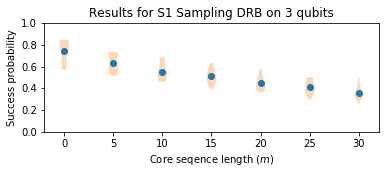

Observed DRB decay


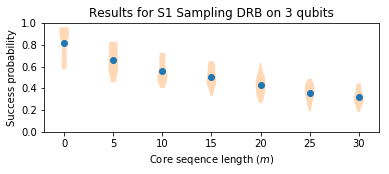

In [28]:
s = 'S1'
n = 3
print("Simulated DRB decay")
plot_data(simulated_data[s,n])
print("Observed DRB decay")
plot_data(data[s,n])

We then fit the data, using the same procedure as above, except that we now set the asymptote to $1/2^n$, which we know to be the correct asymptote for the simulated error model (because the measurement error is unbiased and the gate errors are unital in this model).

In [29]:
sim_fit = {}
for s in samplers:
    for n in number_of_qubits:
        sim_fit[s,n] = rb.analysis.std_least_squares_data_fitting(simulated_data[s,n].lengths, 
                                                                  simulated_data[s,n].ASPs,
                                                                  n, asymptote=1/2**n, seed=seed[n], 
                                                                  ftype='FA')
sim_number_of_bootstraps = 2000       
for s in samplers:
    for n in number_of_qubits:
        print("Generating {} bootstrapped data for {} sampling on {} qubits... ".format(sim_number_of_bootstraps,s,n),end='')
        simulated_data[s,n].add_bootstrapped_datasets(sim_number_of_bootstraps)
        print("complete.")
        
print('')
sim_bootstrapped_r = {}
sim_failcount = {}
for s in samplers:
    for n in number_of_qubits:
        sim_bootstrapped_r[s,n] = []
        sim_failcount[s,n] = 0
        print("Analyzing bootstrapped data for {} sampling on {} qubits... ".format(s,n),end='')
        for i in range(sim_number_of_bootstraps):
            sim_bs_fit = rb.analysis.std_least_squares_data_fitting(simulated_data[s,n].lengths, 
                                                                    simulated_data[s,n].bootstraps[i].ASPs,
                                                                    n, asymptote=1/2**n, seed=seed[n], 
                                                                    ftype='FA')
            if sim_bs_fit['success']:                
                sim_bootstrapped_r[s,n].append(sim_bs_fit['estimates']['r'])
            else:
                sim_failcount[s,n] += 1
        print("complete.")  
        
sim_r = {}
sim_r_std = {}
for s in samplers:
    for n in number_of_qubits:
        sim_r[s,n] = sim_fit[s,n]['estimates']['r']
        sim_r_std[s,n] = np.std(np.array(sim_bootstrapped_r[s,n]))

Generating 2000 bootstrapped data for S1 sampling on 2 qubits... complete.
Generating 2000 bootstrapped data for S1 sampling on 3 qubits... complete.
Generating 2000 bootstrapped data for S1 sampling on 4 qubits... complete.
Generating 2000 bootstrapped data for S1 sampling on 5 qubits... complete.
Generating 2000 bootstrapped data for S2 sampling on 2 qubits... complete.
Generating 2000 bootstrapped data for S2 sampling on 3 qubits... complete.
Generating 2000 bootstrapped data for S2 sampling on 4 qubits... complete.
Generating 2000 bootstrapped data for S2 sampling on 5 qubits... complete.

Analyzing bootstrapped data for S1 sampling on 2 qubits... complete.
Analyzing bootstrapped data for S1 sampling on 3 qubits... complete.
Analyzing bootstrapped data for S1 sampling on 4 qubits... complete.
Analyzing bootstrapped data for S1 sampling on 5 qubits... complete.
Analyzing bootstrapped data for S2 sampling on 2 qubits... complete.
Analyzing bootstrapped data for S2 sampling on 3 qubit

Now that we have done the analysis, for DRB with each circuit sampling and each number of qubits $n$, we can compare three different DRB error rates: 
1. The observed DRB error rate $r$.
2. The calibration data + simulation predicted $r$.
3. The calibration data + theory predicted $r$.

(2) and (3) are in reasonable agreement. This is additional evidence for our theory of DRB -- that DRB measures the sampling-averaged error rate of the gates.

But (1) and (2) [or (3)] are significantly different for $n > 2$ (as already discussed earlier). This implies that, in this device, 1- and 2-qubit CRB (or DRB) is not predictive of $n>2$ qubit DRB.

In [30]:
for n in number_of_qubits:
    for s in samplers:
        r[s,n] =  fit[s,n]['estimates']['r']
        print("Calibration + simulation predicted r for {} sampling and {} qubits: {:0.3} +/- {:0.2}".format(s,n,sim_r[s,n],sim_r_std[s,n]))
        print("   Calibration + theory  predicted r for {} sampling and {} qubits: {:0.3} ".format(s,n,cal_predicted_r[s,n]))
        print("                          observed r for {} sampling and {} qubits: {:0.3} +/- {:0.2}".format(s,n,r[s,n],r_std[s,n]))
        print('')

Calibration + simulation predicted r for S1 sampling and 2 qubits: 0.0277 +/- 0.00065
   Calibration + theory  predicted r for S1 sampling and 2 qubits: 0.0279 
                          observed r for S1 sampling and 2 qubits: 0.0264 +/- 0.00071

Calibration + simulation predicted r for S2 sampling and 2 qubits: 0.013 +/- 0.00058
   Calibration + theory  predicted r for S2 sampling and 2 qubits: 0.0134 
                          observed r for S2 sampling and 2 qubits: 0.0108 +/- 0.00037

Calibration + simulation predicted r for S1 sampling and 3 qubits: 0.0305 +/- 0.0014
   Calibration + theory  predicted r for S1 sampling and 3 qubits: 0.0298 
                          observed r for S1 sampling and 3 qubits: 0.0427 +/- 0.0021

Calibration + simulation predicted r for S2 sampling and 3 qubits: 0.0162 +/- 0.0011
   Calibration + theory  predicted r for S2 sampling and 3 qubits: 0.015 
                          observed r for S2 sampling and 3 qubits: 0.0177 +/- 0.0014

Calibration + 

Finally, we can also simulate DRB using the calibration-data-based model of IBMQX5 and independently sampled DRB circuits.

To do this we need a method of generating new DRB circuits. The cell below does this, using the same sampling parameters / stabilizer compilers as used in the experiments. For more information on how to do this in general (e.g., with different sampling parameters) see the `pyGSTi` tutorials and documentation.

Generating all of these circuits is slow, because we used randomized compilers. Moreover, once the circuits are generated, the simulation of these circuits is as slow as in the case above. So, again, we have already saved data from new circuits, which is imported if `dosims` is False. If `dosims` is True, new circuits are sampled, new data is generated from these circuits, and this is written to file.

In [31]:
dosims = False

In [32]:
# If dosims is True we generate a new set of circuits.
if dosims:
    # A dictionary containing the needed parameters to generate new RB sequences using the same sampling/compilers etc.
    gendict = metadata.drb_circuit_gen_args
    # A dict containing the circuits, and the spec of the RB experiments
    expdict = {}
    for s in samplers:
        for n in number_of_qubits:
            print('\n---- Sampling a new set of DRB circuits with {} sampling on {} qubits ----'.format(s,n),end='\n\n')        
            expdict[s,n] = rb.sample.direct_rb_experiment(*gendict[s,n])

In [33]:
# If domsims is True, we simulate these new circuits (with the same error model as above).
if dosims:

    # This should be set to 1024, but it can be reduced for quick simulations 
    # with less total counts per circuit
    simulation_totalcounts_NCs = 1024
    simulated_data_NCs = {}

    for s in samplers:
        for n in number_of_qubits:
            print("\n\n---- Simulating {} sampling DRB on {} qubits ----\n".format(s,n))
            
            simulated_successcounts_NCs = []
            circuitdepths_NCs = []
            circuit2QGc_NCs = []
            drb_lengths_NCs = []
            
            print("  - Number of circuits to simulate = {}".format(len(list(expdict[s,n]['circuits'].keys()))))
            print("  - Number of simulatations complete = ",end='')
            i = 0
            for key in list(expdict[s,n]['circuits'].keys()):
                ctriple = expdict[s,n]['circuits'][key]
                drb_lengths_NCs.append(ctriple[1].depth()) 
                fullcircuit = ctriple[0]
                fullcircuit.append_circuit(ctriple[1])  
                fullcircuit.append_circuit(ctriple[2])   
                outcome_dict = rb.simulate.circuit_simulator_for_tensored_independent_pauli_errors(fullcircuit, 
                                                                                                    pspec[n], 
                                                                                                    pauli_errors[s,n], 
                                                                                                    simulation_totalcounts_NCs, 
                                                                                                    alloutcomes=True)
                sc = outcome_dict[tuple(0 for i in range(n))]
                simulated_successcounts_NCs.append(sc)
                circuitdepths_NCs.append(fullcircuit.depth())
                circuit2QGc_NCs.append(fullcircuit.twoQgate_count())
                print('{},'.format(i+1),end='')
                i += 1

            simulated_data_NCs[s,n] = rb.results.RBSummaryDataset(n, drb_lengths_NCs, 
                                                              success_counts=simulated_successcounts_NCs,
                                                              total_counts=simulation_totalcounts_NCs,
                                                                circuit_depths=circuitdepths_NCs,
                                                               circuit_twoQgate_counts = circuit2QGc_NCs)

            sim_filename = 'simdata/'+s+'_'+str(n)+'Q_calibration_data_based_simulated_data_newcircuits.txt'       
            rb.io.write_rb_summary_data_to_file(simulated_data_NCs[s,n],sim_filename)

# If we do not implement the simulations, we import data previously generated using this code.
else:
    simulated_data_NCs = {}
    for s in samplers:
        for n in number_of_qubits:
            sim_filename = 'simdata/'+s+'_'+str(n)+'Q_calibration_data_based_simulated_data_newcircuits.txt'             
            simulated_data_NCs[s,n] = rb.io.import_rb_summary_data(sim_filename)

Importing simdata/S1_2Q_calibration_data_based_simulated_data_newcircuits.txt...Complete.
Importing simdata/S1_3Q_calibration_data_based_simulated_data_newcircuits.txt...Complete.
Importing simdata/S1_4Q_calibration_data_based_simulated_data_newcircuits.txt...Complete.
Importing simdata/S1_5Q_calibration_data_based_simulated_data_newcircuits.txt...Complete.
Importing simdata/S2_2Q_calibration_data_based_simulated_data_newcircuits.txt...Complete.
Importing simdata/S2_3Q_calibration_data_based_simulated_data_newcircuits.txt...Complete.
Importing simdata/S2_4Q_calibration_data_based_simulated_data_newcircuits.txt...Complete.
Importing simdata/S2_5Q_calibration_data_based_simulated_data_newcircuits.txt...Complete.


As with the other simulated data, we fit this additional simulated data.

In [34]:
sim_fit_NCs = {}
for s in samplers:
    for n in number_of_qubits:
        sim_fit_NCs[s,n] = rb.analysis.std_least_squares_data_fitting(simulated_data_NCs[s,n].lengths, 
                                                                  simulated_data_NCs[s,n].ASPs,
                                                                  n, asymptote=1/2**n, seed=seed[n], 
                                                                  ftype='FA')
sim_number_of_bootstraps_NCs = 2000       
for s in samplers:
    for n in number_of_qubits:
        print("Generating {} bootstrapped datsets... ".format(sim_number_of_bootstraps_NCs),end='')
        simulated_data_NCs[s,n].add_bootstrapped_datasets(sim_number_of_bootstraps_NCs)
        print("complete.")
        
print('')
sim_bootstrapped_r_NCs = {}
sim_failcount_NCs = {}
for s in samplers:
    for n in number_of_qubits:
        sim_bootstrapped_r_NCs[s,n] = []
        sim_failcount_NCs[s,n] = 0
        print("Analyzing bootstrapped data for {} sampling on {} qubits... ".format(s,n),end='')
        for i in range(sim_number_of_bootstraps_NCs):
            sim_bs_fit_NCs = rb.analysis.std_least_squares_data_fitting(simulated_data_NCs[s,n].lengths, 
                                                                    simulated_data_NCs[s,n].bootstraps[i].ASPs,
                                                                    n, asymptote=1/2**n, seed=seed[n], 
                                                                    ftype='FA')
            if sim_bs_fit['success']:                
                sim_bootstrapped_r_NCs[s,n].append(sim_bs_fit_NCs['estimates']['r'])
            else:
                sim_failcount_NCs[s,n] += 1
        print('complete.')
        
sim_r_NCs = {}
sim_r_std_NCs = {}
for s in samplers:
    for n in number_of_qubits:
        sim_r_NCs[s,n] = sim_fit_NCs[s,n]['estimates']['r']
        sim_r_std_NCs[s,n] = np.std(np.array(sim_bootstrapped_r_NCs[s,n]))

Generating 2000 bootstrapped datsets... complete.
Generating 2000 bootstrapped datsets... complete.
Generating 2000 bootstrapped datsets... complete.
Generating 2000 bootstrapped datsets... complete.
Generating 2000 bootstrapped datsets... complete.
Generating 2000 bootstrapped datsets... complete.
Generating 2000 bootstrapped datsets... complete.
Generating 2000 bootstrapped datsets... complete.

Analyzing bootstrapped data for S1 sampling on 2 qubits... complete.
Analyzing bootstrapped data for S1 sampling on 3 qubits... complete.
Analyzing bootstrapped data for S1 sampling on 4 qubits... complete.
Analyzing bootstrapped data for S1 sampling on 5 qubits... complete.
Analyzing bootstrapped data for S2 sampling on 2 qubits... complete.
Analyzing bootstrapped data for S2 sampling on 3 qubits... complete.
Analyzing bootstrapped data for S2 sampling on 4 qubits... complete.
Analyzing bootstrapped data for S2 sampling on 5 qubits... complete.


We can then compare these simulation results to those from the other simulated data (that used the same circuits as in the DRB experiments). As we can see, and unsurprisingly, the data from the independently sampled circuits is broadly consistent with the data from the circuits we used in the experiments.

In [35]:
for n in number_of_qubits:
    for s in samplers:
        print("Calibration + simulation with experiment circuits r for {} sampling and {} qubits: {:0.3} +/- {:0.2}".format(s,n,sim_r[s,n],sim_r_std[s,n]))
        print("       Calibration + simulation with new circuits r for {} sampling and {} qubits: {:0.3} +/- {:0.2}".format(s,n,sim_r_NCs[s,n],sim_r_std_NCs[s,n]))
        print("")

Calibration + simulation with experiment circuits r for S1 sampling and 2 qubits: 0.0277 +/- 0.00065
       Calibration + simulation with new circuits r for S1 sampling and 2 qubits: 0.0281 +/- 0.00058

Calibration + simulation with experiment circuits r for S2 sampling and 2 qubits: 0.013 +/- 0.00058
       Calibration + simulation with new circuits r for S2 sampling and 2 qubits: 0.0129 +/- 0.00056

Calibration + simulation with experiment circuits r for S1 sampling and 3 qubits: 0.0305 +/- 0.0014
       Calibration + simulation with new circuits r for S1 sampling and 3 qubits: 0.0287 +/- 0.0011

Calibration + simulation with experiment circuits r for S2 sampling and 3 qubits: 0.0162 +/- 0.0011
       Calibration + simulation with new circuits r for S2 sampling and 3 qubits: 0.0131 +/- 0.00099

Calibration + simulation with experiment circuits r for S1 sampling and 4 qubits: 0.0395 +/- 0.0014
       Calibration + simulation with new circuits r for S1 sampling and 4 qubits: 0.0376 +/-

## 4. Estimating average CNOT error rates
Finally, we estimate the average error rate of the CNOT gates in $n$-qubit circuits, by comparing the DRB results under the two different sampling distributions (for a fixed number of qubits $n$).

As discussed in the main text, according to our theory of DRB
\begin{equation} \begin{pmatrix} r_{0.75} \\ r_{0.25} \end{pmatrix}  = \frac{1}{4} \begin{pmatrix} 3 & 1 \\ 1 & 3 \end{pmatrix}\begin{pmatrix} \epsilon_{A} \\ \epsilon_{B} \end{pmatrix}\end{equation}
where $r_{0.75}$ (resp., $r_{0.25}$) is the $r$ obtained with $p_{cnot} = 0.75$ (resp., $p_{cnot} = 0.25$) sampling corresponding to the label "S1" ("S2") in this notebook; $\epsilon_A$ (resp., $\epsilon_B$) is the average error rate of those $n$-qubit gates containing one CNOT in parallel with 1-qubit gates on the other qubits (resp., $n$ parallel 1-qubit gates).

So, to estimate the mean CNOT error rate, we:
1. Estimate $\epsilon_A$ and $\epsilon_B$ by apply $M^{-1}$ to the vector $ (r_{0.75}, r_{0.25} )$.
2. Estimate the error rate of a 1-qubit gate as $\epsilon_{1Q} = 1-(1-\epsilon_B)^{1/n}$. 
3. Estimating the CNOT error rate as $\epsilon_{cnot} = 1 - (1 - \epsilon_A)/(1-\epsilon_{1Q})^{n-2}$.

The function below does this analysis, which we then implement for each $n$.

In [36]:
def estimated_CNOT_error_rate(rvec,Minv,n):
    
    evec = np.dot(Minv,rvec)
    parallel_oneQgate_error_rate = evec[0]
    oneQgate_error_rate = 1 - (1 - parallel_oneQgate_error_rate)**(1/n)
    cnot_error_rate = 1 - (1-evec[1]) / (1-oneQgate_error_rate)**(n-2)
    
    return cnot_error_rate, oneQgate_error_rate, evec

Below, for each $n$ we print out our estimates of: the vector $(\epsilon_{A} , \epsilon_{B})$, the CNOT error rate, and the 1-qubit error rate:

In [37]:
M = np.array([[1,3],[3,1]])/4
Minv = np.linalg.inv(M)

evec = {}
ecnot = {}
e1Q = {}

for n in number_of_qubits:
    rvec = np.array([r['S1',n],r['S2',n]])
    ecnot[n], e1Q[n], evec[n] = estimated_CNOT_error_rate(rvec,Minv,n)
    print(n, evec[n], ecnot[n], e1Q[n])    

2 [0.00291473 0.03429207] 0.034292074773721426 0.0014584275787904444
3 [0.00519608 0.05516431] 0.05352213755374191 0.0017350362495155425
4 [0.01144188 0.08769893] 0.0824344849027574 0.0028728268329002438
5 [0.01695979 0.20839739] 0.20023122100805324 0.0034152061329707495


The CNOT error rate is not a linear function of the DRB error rates, so we don't use the linear propogation of uncertainty formula to obtain estimation uncertainties. Instead, we estimate this uncertainty using the bootstrapped data.

In [38]:
bs_evec = {}
bs_ecnot = {}
bs_e1Q = {}

ecnot_std = {}
e1Q_std = {}

for n in number_of_qubits:
    bs_evec[n] = []
    bs_ecnot[n] = []
    bs_e1Q[n] = []
    for i in range(number_of_bootstraps):
        bootstrapped_rvec =np.array([bootstrapped_r['S1',n][i],bootstrapped_r['S2',n][i]])
        a, b, c = estimated_CNOT_error_rate(bootstrapped_rvec,Minv,n)
        bs_ecnot[n].append(a)
        bs_e1Q[n].append(b)
        bs_evec[n].append(c)
    
    ecnot_std[n] = np.std(np.array(bs_ecnot[n]))
    e1Q_std[n] = np.std(np.array(bs_e1Q[n]))
    print("Mean CNOT error rate in {} qubit circuits = {:0.4} +/- {:0.4}".format(n,ecnot[n],ecnot_std[n]))

Mean CNOT error rate in 2 qubit circuits = 0.03429 +/- 0.001097
Mean CNOT error rate in 3 qubit circuits = 0.05352 +/- 0.003695
Mean CNOT error rate in 4 qubit circuits = 0.08243 +/- 0.008494
Mean CNOT error rate in 5 qubit circuits = 0.2002 +/- 0.0612


We can also compare this to predictions (based on 2-qubit Clifford RB) obtained from the calibration data.

In [39]:
print("-------------- Prediction from calibration data ---------------")
for n in number_of_qubits:
    print("Mean CNOT error rate is between = {:0.4} (S1 data) and = {:0.4} (S2 data)".format(mean_twoQ_gate_error_rate['S1',n],mean_twoQ_gate_error_rate['S2',n]))

-------------- Prediction from calibration data ---------------
Mean CNOT error rate is between = 0.03506 (S1 data) and = 0.03736 (S2 data)
Mean CNOT error rate is between = 0.03412 (S1 data) and = 0.03362 (S2 data)
Mean CNOT error rate is between = 0.04395 (S1 data) and = 0.0449 (S2 data)
Mean CNOT error rate is between = 0.04451 (S1 data) and = 0.04625 (S2 data)


To check that the standard-deviation based confidence regions are meaningful, we can look at the histograms of the bootstrapped CNOT error rate estimates to check that they look reasonably Gaussian.

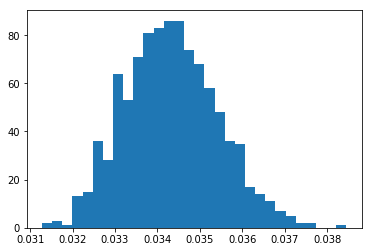

In [40]:
n = 2
plt.hist(bs_ecnot[n],bins=30)
plt.show()